## copy of environment class

TODO: reproduce work from agent based here

In [268]:
import gym
from gym import spaces
from typing import Optional
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import os
import glob
import logging
import json
import random
import time
import torch
from collections import Counter
from typing import Optional
sns.set_theme()


def restructure_edges(network):
    """
    This function restructures the edges from list of dicts
    to one dict, to improve construction of edges matrix and 
    env vectorization
    """

    new_edges= {'source_id':[],'target_id':[],'reward':[]}
    for e in network['edges']:
        new_edges['source_id'].append(e['source_id'])
        new_edges['target_id'].append(e['target_id'])
        new_edges['reward'].append(e['reward'])
    return new_edges 


class Reward_Network(gym.Env):
    
    def __init__(self, network, to_log=False):
        
        #-------------
        # assert tests TODO
        #-------------

        # reward network information from json file (can be just one network or multiple networks)
        self.network = network
       
        # initial reward and step values
        self.INIT_REWARD = 0
        self.INIT_STEP = 0
        self.MAX_STEP = 8
        self.N_NODES = 10
        self.N_NETWORKS = len(self.network)

        # define node numbers (from 0 to 9)
        self.nodes = torch.stack([torch.arange(10)]*self.N_NETWORKS,dim = 0)
        # define starting nodes
        self.starting_nodes = torch.tensor(list(map(lambda n: n['starting_node'], self.network)), dtype=torch.long)
        # define possible rewards along with corresponding reward index
        self.possible_rewards = {-100:1, -20:2, 0:3, 20:4, 140:5}

        # initialize action space ("reward adjacency matrix")
        # NOTE intially I thought about the value 0 to be the value that signals that there is no edge between two nodes,
        # however since 0 is also a possible reward I have put 1 as the value in the reward adjacency matrix that represents
        # no edge between two nodes

        # Levin: moving this line into the for loop was the crucial bit fixing
        # the error
        # buffer_action_space = torch.full((self.N_NODES, self.N_NODES), 1).long()  
        
        self.action_space = torch.full((self.N_NETWORKS,self.N_NODES, self.N_NODES), 1).long()  
        self.new_edges = list(map(restructure_edges,network))
        self.network_idx = torch.arange(self.N_NETWORKS, dtype=torch.long)
        for n in range(self.N_NETWORKS):
            # Levin: the buffer needs to be cleared before resigning it for a
            # new networks (otherwise you might keep rewards from the previous
            # network)            

            buffer_action_space = torch.full((self.N_NODES, self.N_NODES), 1).long()  
            source = torch.tensor(self.new_edges[n]['source_id']).long()
            target = torch.tensor(self.new_edges[n]['target_id']).long()
            reward = torch.tensor(self.new_edges[n]['reward']).long()
            
            buffer_action_space[source,target]=reward
            self.action_space[n,:,:] = buffer_action_space

        # get adjacency matrix with reward index instead of actual reward
        # 0 here means that no edge is present, all other indices from 1 to 5 indicate a reward
        # (the higher the index number, the higher the reward)
        # (using this solution for now: https://discuss.pytorch.org/t/mapping-values-in-a-tensor/117731)
        self.action_space_idx = self.action_space.detach().clone()
        self.action_space_idx.apply_(lambda val: self.possible_rewards.get(val, 0))

        # ---- one general remark
        # Levin: . I would recommend to define the action
        # space in terms of action_idx. Someone could
        # define a new reward == 1 and this will
        # break everything (this is unlike, I argue from a principal
        # perspective). Having a reward_idx = 0 that reflects invalid actions is
        # somewhat nicer, then a reward = 1, that reflects invalid actions.
        # You can define a reward map
        self.reward_map = torch.zeros(max(self.possible_rewards.values()) + 1, dtype=torch.long)
        self.reward_map[list(self.possible_rewards.values())] = torch.tensor(list(self.possible_rewards.keys()), dtype=torch.long)
        # if you then want to turn a action_idx into action_reward you can do
        # simple by reward_map[action_idx]
        reward_map_for_testing = self.reward_map.clone()
        reward_map_for_testing[0] = 1
        torch.testing.assert_allclose(self.action_space, reward_map_for_testing[self.action_space_idx])        
        # ---- end of one general remark


        # boolean adjacency matrix 
        self.edge_is_present = torch.squeeze(torch.unsqueeze(self.action_space!=1,dim=-1))
        
        #self.all_edges_source = [torch.where(self.action_space[i,:,:]!=1)[0] for i in range(self.N_NETWORKS)] 
        #self.all_edges_target = [torch.where(self.action_space[i,:,:]!=1)[1] for i in range(self.N_NETWORKS)] 
        


    def reset(self):
        # Reset the state of the environment to an initial state
        self.reward_balance = torch.full((self.N_NETWORKS,1),self.INIT_REWARD)
        self.step_counter = torch.full((self.N_NETWORKS,1),self.INIT_STEP)
        self.is_done = False 
        self.current_node = self.starting_nodes.clone()
        #self.current_node = torch.tensor(list(map(lambda n: n['starting_node'], self.network)), dtype=torch.long)

        print('Environment initialized: \n')
        print(f'- set of nodes of shape {self.nodes.shape}')
        print(f'- action space of shape {self.action_space.shape}')
        print(f'- reward balance of shape {self.reward_balance.shape}')
        print(f'- step counter of shape {self.step_counter.shape}')
        print(f'- current node of shape {self.current_node.shape}')

    
    def step(self, action):
        '''
        Take a step in all environments; here action corresponds to the target nodes for each env
        action_i \in [0,1,2,3,4,5,6,7,8,9]
        '''

        self.source_node = self.current_node
        print(f'Source nodes are: {self.current_node}, we are going to new nodes {action}')

        self.rewards = torch.unsqueeze(self.action_space[self.network_idx,self.current_node,action], dim=-1)

        # TODO remove; only used to validate the equivalence during development
        #rewards_old = torch.unsqueeze( torch.tensor([self.action_space[i,self.current_node[i],action[i]] for i in range(self.N_NETWORKS)]), dim=-1)
        #torch.testing.assert_close(self.rewards, rewards_old)
        # remove end

        print(f'\n')
        self.reward_balance = torch.add(self.reward_balance,self.rewards)
        print(f'We get rewards : {self.rewards[:,0]} and the new reward balance is: {self.reward_balance[:,0]}')
        self.current_node = action
        print(f'Now we are in nodes: {self.current_node}')
        self.step_counter = torch.add(self.step_counter,1)
        print(f'Step counter for all networks is: {self.step_counter[:,0]}')
        print('\n')

        if torch.all(self.step_counter == 8):
            self.is_done = True

        return self.rewards
        
        
    def get_state(self):
        """
        this function returns the current state of the environment.
        State information given by this funciton is less detailed compared
        to the observation. 
        """
        return {'current_node':self.current_node,
                'total_reward':self.reward_balance,
                'n_steps':self.step_counter,
                'done':self.is_done}


    def get_possible_rewards(self,obs):
        """
        this function returns the next possible rewards given an observation;
        the rewards are selected using boolean masking, and the resulting array is split
        into sub-tensors whose size is given by how many valid edges are present in each network
        in the current observation.
        """
        self.n_rewards_per_network = torch.count_nonzero(obs['next_possible_nodes'],dim=1).tolist()
        self.next_rewards_all = torch.masked_select(obs['next_possible_rewards'][self.network_idx],obs['next_possible_nodes'][self.network_idx])
        self.next_rewards_per_network = torch.split(self.next_rewards_all,self.n_rewards_per_network)
        
        return self.next_rewards_per_network

    def observe(self):
        """
        TODO: CHANGE FOR VECTORIZATION
        this function returns observation from the environment
        """
        #self.valid_edges_source = [torch.where(self.all_edges_source[i]==self.current_node[i])[:] for i in range(self.N_NETWORKS)]
        #self.valid_edges_target = [self.all_edges_target[i][self.valid_edges_source[i]] for i in range(self.N_NETWORKS)]
        
        self.next_nodes = torch.squeeze(torch.unsqueeze(self.edge_is_present[self.network_idx,self.current_node,:],dim=-1))
        self.next_rewards = torch.squeeze(torch.unsqueeze(self.action_space[self.network_idx,self.current_node,:],dim=-1))
        self.next_rewards_idx = torch.squeeze(torch.unsqueeze(self.action_space_idx[self.network_idx,self.current_node,:],dim=-1))

        return {'current_node':self.current_node,
                'next_possible_nodes':self.next_nodes,#torch.squeeze(torch.unsqueeze(self.next_nodes[self.network_idx,self.network_idx,:],dim=-1)) ,
                'next_possible_rewards':self.next_rewards, #torch.squeeze(torch.unsqueeze(self.next_rewards[self.network_idx,self.network_idx,:],dim=-1)),
                'next_possible_rewards_idx':self.next_rewards_idx,
                'total_reward':self.reward_balance,
                'n_steps':self.step_counter,
                'done':self.is_done}

## Agent that uses pytorch functions to solve multiple environments

In [269]:
class Agent:

    def __init__(self,strategy: str, n_envs: int):
        """
        initialize agent
        """
        assert strategy in ['random','highest_payoff','take_first_loss'], f'a strategy {strategy} was given, but availabe strategies are {["random","highest_payoff","take_loss"]}'
        assert n_envs>0, f'Invalid number of environments, must be at least 1'
        
        self.strategy = strategy
        self.n_envs = n_envs
        self.possible_rewards = {-100:1, -20:2, 0:3, 20:4, 140:5}
        self.large_loss_idx = 1

        # initialize loss counter for loss strategy
        if strategy=='take_first_loss':
            self.loss_counter=torch.zeros(self.n_envs)

        self.env_index = torch.arange(0, self.n_envs, 1)

    def choose_action(self,obs):
        """
        Choose next action given an observation and a strategy
        """
        # print(f"Shape of the next possible rewards (index) matrix: {obs['next_possible_rewards_idx'].shape}")
        next_action = torch.zeros(self.n_envs,dtype=torch.long)

        #-----RANDOM------
        if self.strategy=='random':
            next_action = torch.squeeze(torch.multinomial(obs['next_possible_nodes'].type(torch.float),1))

        else:
            # Levin:
            # The first large loss is a compose strategy, where we most of the times
            # follow the highest payoff strategy, but sometimes we deviate. To make
            # this easier, let's first just calculate the highest_payoff_action
            # and then figure out in which cases we take a large loss instead. 
            # General rule in torch: Better few large operations, than many
            # small operations.
            # Thus: calculating a bit to much in a big operation and "wasting" it is in generally
            # preferred, if it saves you from many lines separate operations
            # later on. Such a approach is usually fast, but, more important for
            # our purpose, also easier to read.

            # one general comment: I have seen you many times adding variable as
            # properties (i.e. self.next_action). You might only want to do
            # that, if the variable needs to be accessed at a later call of the
            # agent. loss_counter is a great example, where this is necessary.
            # In the case of next_action a normal internal variable is sufficiently

            #-----HIGHEST PAYOFF------
            max_avaible_reward_idx = torch.max(obs['next_possible_rewards_idx'],dim=1)[0]
            p = torch.squeeze(
                obs['next_possible_rewards_idx'].unsqueeze(0) == max_avaible_reward_idx.unsqueeze(1),dim=0)
            highest_payoff_action = torch.squeeze(torch.multinomial(p.type(torch.float),1))

            if self.strategy=='highest_payoff':
                next_action = highest_payoff_action
            elif self.strategy=='take_first_loss':
                # Levin: let's figure out, when to take a large loss
                # min_avaible_reward_idx = torch.min(obs['next_possible_rewards_idx'],dim=1)[0]
                large_loss_is_avaible = torch.any(obs['next_possible_rewards_idx'] == self.large_loss_idx, dim=1)
                print('large_loss_is_avaible',large_loss_is_avaible)
                # print('min_avaible_reward_idx',min_avaible_reward_idx)
                print('next_possible_rewards_idx',obs['next_possible_rewards_idx'])
                take_large_loss = (self.loss_counter == 0) & large_loss_is_avaible
                
                # Levin: select the large loss action, in case we know we want to take it
                p = torch.squeeze(
                    obs['next_possible_rewards_idx'][take_large_loss].unsqueeze(0) == self.large_loss_idx,dim=0)
                large_loss_action = torch.squeeze(torch.multinomial(p.type(torch.float),1))

                # Levin: take the highest payoff strategy, and replace the action where
                # we like to take a large loss instead
                first_large_loss_action = highest_payoff_action.clone()
                first_large_loss_action[take_large_loss] = large_loss_action
                self.loss_counter += take_large_loss.type(torch.int)
                next_action = first_large_loss_action
            else:
                raise ValueError(f"Unkown strategy {self.strategy}")
        
        return next_action

## load a few networks and test (with random policy)

In [270]:
project_folder = ".."
data_dir = os.path.join(project_folder,'data')

with open(os.path.join(data_dir,'train.json')) as json_file:
    train = json.load(json_file)

test = train[10:13]

In [271]:
N = Reward_Network(test)
A = Agent('take_first_loss',len(test))
N.reset()

Environment initialized: 

- set of nodes of shape torch.Size([3, 10])
- action space of shape torch.Size([3, 10, 10])
- reward balance of shape torch.Size([3, 1])
- step counter of shape torch.Size([3, 1])
- current node of shape torch.Size([3])


/Users/levinbrinkmann/repros/reward-network-iii-algorithm/.venv/lib/python3.9/site-packages/torch/testing/_deprecated.py:35: FutureWarning: torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.
  warnings.warn(msg, FutureWarning)


In [272]:
N.reward_map

tensor([   0, -100,  -20,    0,   20,  140])

In [273]:
N.action_space[0,:,:]

tensor([[   1,    1,    1,   20,  -20,    1,    1,    1,    1,    1],
        [   1,    1,  -20,   20,    1,    1,    1,    1,    1,    1],
        [  20,    1,    1,    1,    1,    1, -100,    1,    1,    1],
        [   1,    0,    1,    1,   20,    1,    1,    1,    1,    1],
        [   0,   20,    1,    1,    1,    1,    1,    1,    1,    1],
        [   1,    1,    1,    1,    1,    1,    0,    1,   20,    1],
        [   1,    1,    1,    1,    1,    1,    1,   20,    0,    1],
        [   1,    1,    1,    1,    1,    0,    1,    1,    1,   20],
        [   1,    1,    1,    1,    1,  -20,    1,    0,    1,    1],
        [   1,    1,   20,    1,    1,    1,    1,    1,  140,    1]])

In [274]:
N.observe()

{'current_node': tensor([0, 0, 0]),
 'next_possible_nodes': tensor([[False, False, False,  True,  True, False, False, False, False, False],
         [False, False, False,  True, False, False,  True, False, False, False],
         [False, False,  True, False,  True, False, False, False, False, False]]),
 'next_possible_rewards': tensor([[   1,    1,    1,   20,  -20,    1,    1,    1,    1,    1],
         [   1,    1,    1,  -20,    1,    1, -100,    1,    1,    1],
         [   1,    1,  -20,    1,   20,    1,    1,    1,    1,    1]]),
 'next_possible_rewards_idx': tensor([[0, 0, 0, 4, 2, 0, 0, 0, 0, 0],
         [0, 0, 0, 2, 0, 0, 1, 0, 0, 0],
         [0, 0, 2, 0, 4, 0, 0, 0, 0, 0]]),
 'total_reward': tensor([[0],
         [0],
         [0]]),
 'n_steps': tensor([[0],
         [0],
         [0]]),
 'done': False}

In [275]:
# NEW: Using the observation to step in the environment
outputs = []
while N.is_done==False:
    print(f'Current node in the envs: {N.current_node}')
    print('---------------------------------------------')

    obs = N.observe()
    possible_rewards = N.get_possible_rewards(obs)

    # select action based on observation
    next_action = A.choose_action(obs)
    print(f'Next actions chosen: {next_action}')
    print(f'Loss counter: {A.loss_counter}')
    # take a step in envs
    rewards = N.step(next_action)
    #print(f'rewards: {rewards} with size {rewards.shape}')
    outputs.append(rewards)

results = torch.squeeze(torch.stack(outputs,dim=1),dim=-1)
results.shape

Current node in the envs: tensor([0, 0, 0])
---------------------------------------------
large_loss_is_avaible tensor([False,  True, False])
next_possible_rewards_idx tensor([[0, 0, 0, 4, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 0, 0, 1, 0, 0, 0],
        [0, 0, 2, 0, 4, 0, 0, 0, 0, 0]])
Next actions chosen: tensor([3, 6, 4])
Loss counter: tensor([0., 1., 0.])
Source nodes are: tensor([0, 0, 0]), we are going to new nodes tensor([3, 6, 4])


We get rewards : tensor([  20, -100,   20]) and the new reward balance is: tensor([  20, -100,   20])
Now we are in nodes: tensor([3, 6, 4])
Step counter for all networks is: tensor([1, 1, 1])


Current node in the envs: tensor([3, 6, 4])
---------------------------------------------
large_loss_is_avaible tensor([False, False, False])
next_possible_rewards_idx tensor([[0, 3, 0, 0, 4, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 3, 4, 0],
        [3, 0, 0, 2, 0, 0, 0, 0, 0, 0]])
Next actions chosen: tensor([4, 8, 0])
Loss counter: tensor([0., 1., 0

torch.Size([3, 8])

## Replicate results from agent based notebook

In [276]:
network_ids = [i['network_id'] for i in train]

In [277]:
N = Reward_Network(train)
A = Agent('highest_payoff',len(train))
N.reset()

# HIGHEST PAYOFF
outputsA = []

while N.is_done==False:
    print(f'Current node in the envs: {N.current_node}')
    print('---------------------------------------------')

    obs = N.observe()
    possible_rewards = N.get_possible_rewards(obs)
    
    # select action based on observation
    next_actionA = A.choose_action(obs)
    print(f'Next actions chosen: {next_actionA}')
    # take a step in envs
    rewards = N.step(next_actionA)
    outputsA.append(rewards)

resultsA = torch.squeeze(torch.stack(outputsA,dim=1),dim=-1)
print(f'FINISHED! We obtain a results tensor of shape {resultsA.shape}')
resultsA_df = pd.DataFrame(resultsA.numpy(), columns = [f'reward_{i}' for i in range(1,9)])

Environment initialized: 

- set of nodes of shape torch.Size([945, 10])
- action space of shape torch.Size([945, 10, 10])
- reward balance of shape torch.Size([945, 1])
- step counter of shape torch.Size([945, 1])
- current node of shape torch.Size([945])
Current node in the envs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [278]:
N = Reward_Network(train)
B = Agent('take_first_loss',len(train))
N.reset()


# TAKE FIRST LOSS
outputsB = []
while N.is_done==False:
    print(f'Current node in the envs: {N.current_node}')
    print('---------------------------------------------')

    obs = N.observe()
    possible_rewards = N.get_possible_rewards(obs)
    
    # select action based on observation
    next_actionB = B.choose_action(obs)
    print(f'Next actions chosen: {next_actionB}')
    # take a step in envs
    rewards = N.step(next_actionB)
    outputsB.append(rewards)

resultsB = torch.squeeze(torch.stack(outputsB,dim=1),dim=-1)
print(f'FINISHED! We obtain a results tensor of shape {resultsB.shape}')
resultsB_df = pd.DataFrame(resultsB.numpy(), columns = [f'reward_{i}' for i in range(1,9)])

Environment initialized: 

- set of nodes of shape torch.Size([945, 10])
- action space of shape torch.Size([945, 10, 10])
- reward balance of shape torch.Size([945, 1])
- step counter of shape torch.Size([945, 1])
- current node of shape torch.Size([945])
Current node in the envs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/Users/levinbrinkmann/repros/reward-network-iii-algorithm/.venv/lib/python3.9/site-packages/torch/testing/_deprecated.py:35: FutureWarning: torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.
  warnings.warn(msg, FutureWarning)


Source nodes are: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [279]:
N = Reward_Network(train)
C = Agent('random',len(train))
N.reset()


# RANDOM
outputsC = []
while N.is_done==False:
    print(f'Current node in the envs: {N.current_node}')
    print('---------------------------------------------')

    obs = N.observe()
    possible_rewards = N.get_possible_rewards(obs)
    
    # select action based on observation
    next_actionC = C.choose_action(obs)
    print(f'Next actions chosen: {next_actionC}')
    # take a step in envs
    rewards = N.step(next_actionC)
    outputsC.append(rewards)

resultsC = torch.squeeze(torch.stack(outputsC,dim=1),dim=-1)
print(f'FINISHED! We obtain a results tensor of shape {resultsC.shape}')
resultsC_df = pd.DataFrame(resultsC.numpy(), columns = [f'reward_{i}' for i in range(1,9)])

/Users/levinbrinkmann/repros/reward-network-iii-algorithm/.venv/lib/python3.9/site-packages/torch/testing/_deprecated.py:35: FutureWarning: torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.
  warnings.warn(msg, FutureWarning)


Environment initialized: 

- set of nodes of shape torch.Size([945, 10])
- action space of shape torch.Size([945, 10, 10])
- reward balance of shape torch.Size([945, 1])
- step counter of shape torch.Size([945, 1])
- current node of shape torch.Size([945])
Current node in the envs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Transform Tensor results to Dataframe

In [280]:
# add network ids
resultsA_df.insert(loc=0, column='network_id', value=network_ids)
resultsB_df.insert(loc=0, column='network_id', value=network_ids)
resultsC_df.insert(loc=0, column='network_id', value=network_ids)

# add cumulative reward column
resultsA_df['total_reward'] = resultsA_df.sum(axis=1)
resultsA_df.head(30)

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_9986/2537788698.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  resultsA_df['total_reward'] = resultsA_df.sum(axis=1)


,network_id,reward_1,reward_2,reward_3,reward_4,reward_5,reward_6,reward_7,reward_8,total_reward
0,612d020c2855f861544a66ea4a8663c4,-20,0,20,20,0,20,20,0,60
1,fc97ced304cff0b64894d2a6bbbfc142,20,0,20,20,0,20,0,20,100
2,8bae2ee9bab910a86f1f97619c84bde7,20,0,20,20,20,0,20,0,100
3,1636fe1921b59a7403f96d8f8f1fcba2,-100,20,20,0,20,-100,20,0,-120
4,988a9097dd397e8bfd0f8d219d04d362,0,0,0,0,0,0,0,0,0
5,f928fa70b461d74873bee961b1b54d79,20,-20,20,-20,20,20,-20,20,40
6,2e88b4462adfdc5a85fee6301df3c574,-20,20,-20,20,-20,20,-20,20,0
7,bc6e64aacaaecdde815fa2f52ae9a08f,0,20,0,20,0,0,-20,20,40
8,d601e40cf010d37c451e09b3dd349bca,20,20,0,0,20,20,20,0,100
9,17256a66eef2c9f467a33108a59c5b09,0,20,0,-20,0,20,0,20,40


In [281]:
resultsA_df[resultsA_df['network_id']=='e9856335f1991c452c677222a4314d9f']

,network_id,reward_1,reward_2,reward_3,reward_4,reward_5,reward_6,reward_7,reward_8,total_reward
163,e9856335f1991c452c677222a4314d9f,20,20,20,20,20,20,20,20,160


In [282]:
resultsB_df['total_reward'] = resultsB_df.sum(axis=1)
resultsB_df.head(30)

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_9986/2101493446.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  resultsB_df['total_reward'] = resultsB_df.sum(axis=1)


,network_id,reward_1,reward_2,reward_3,reward_4,reward_5,reward_6,reward_7,reward_8,total_reward
0,612d020c2855f861544a66ea4a8663c4,-100,0,20,20,20,20,140,0,120
1,fc97ced304cff0b64894d2a6bbbfc142,20,-100,0,20,20,20,20,20,20
2,8bae2ee9bab910a86f1f97619c84bde7,20,-100,20,20,20,20,20,20,40
3,1636fe1921b59a7403f96d8f8f1fcba2,-100,20,20,0,20,-100,0,20,-120
4,988a9097dd397e8bfd0f8d219d04d362,-100,20,0,140,0,20,0,0,80
5,f928fa70b461d74873bee961b1b54d79,-100,0,20,140,0,0,-100,0,-40
6,2e88b4462adfdc5a85fee6301df3c574,-100,20,0,140,20,140,0,140,360
7,bc6e64aacaaecdde815fa2f52ae9a08f,0,-100,0,0,20,0,0,-20,-100
8,d601e40cf010d37c451e09b3dd349bca,20,20,0,0,20,20,20,0,100
9,17256a66eef2c9f467a33108a59c5b09,0,20,0,20,0,20,0,-20,40


In [283]:
resultsC_df['total_reward'] = resultsC_df.sum(axis=1)
resultsC_df.head(30)

/var/folders/nv/p5tx0nn545v9h6_w1wtm8cg00000gn/T/ipykernel_9986/3557286971.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  resultsC_df['total_reward'] = resultsC_df.sum(axis=1)


,network_id,reward_1,reward_2,reward_3,reward_4,reward_5,reward_6,reward_7,reward_8,total_reward
0,612d020c2855f861544a66ea4a8663c4,-100,0,20,20,140,-20,0,20,80
1,fc97ced304cff0b64894d2a6bbbfc142,20,0,20,0,20,20,-100,0,-20
2,8bae2ee9bab910a86f1f97619c84bde7,20,-100,20,20,20,140,-100,20,40
3,1636fe1921b59a7403f96d8f8f1fcba2,-100,-20,-100,0,-20,20,-100,0,-320
4,988a9097dd397e8bfd0f8d219d04d362,0,0,0,-20,0,-100,20,0,-100
5,f928fa70b461d74873bee961b1b54d79,-100,0,20,20,20,-20,20,20,-20
6,2e88b4462adfdc5a85fee6301df3c574,-20,0,-20,20,20,0,-100,-20,-120
7,bc6e64aacaaecdde815fa2f52ae9a08f,0,-100,0,0,20,0,-100,0,-180
8,d601e40cf010d37c451e09b3dd349bca,20,-20,0,0,20,20,0,20,60
9,17256a66eef2c9f467a33108a59c5b09,-20,0,-20,-20,0,20,0,-20,-60


/Users/levinbrinkmann/repros/reward-network-iii-algorithm/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


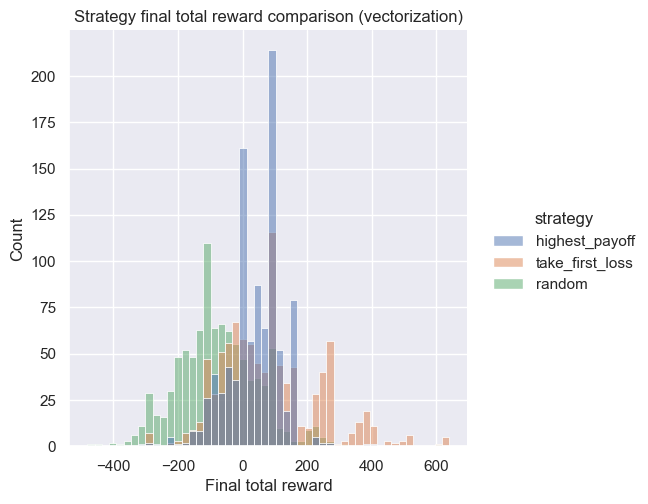

In [284]:
resultsA_df['strategy'] = 'highest_payoff'
resultsB_df['strategy'] = 'take_first_loss'
resultsC_df['strategy'] = 'random'

strategy_data_final=pd.concat([resultsA_df[['network_id','strategy','total_reward']],
                               resultsB_df[['network_id','strategy','total_reward']],
                               resultsC_df[['network_id','strategy','total_reward']]], ignore_index=True)

# hist plot
g=sns.displot(data=strategy_data_final, x="total_reward", hue="strategy", kind="hist")
g.set(xlabel='Final total reward',ylabel='Count',title=f'Strategy final total reward comparison (vectorization)')
plt.show()

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
    group1          group2      meandiff p-adj   lower     upper   reject
-------------------------------------------------------------------------
highest_payoff          random -115.0688   0.0 -128.2841 -101.8535   True
highest_payoff take_first_loss   43.3862   0.0    30.171   56.6015   True
        random take_first_loss   158.455   0.0  145.2397  171.6703   True
-------------------------------------------------------------------------


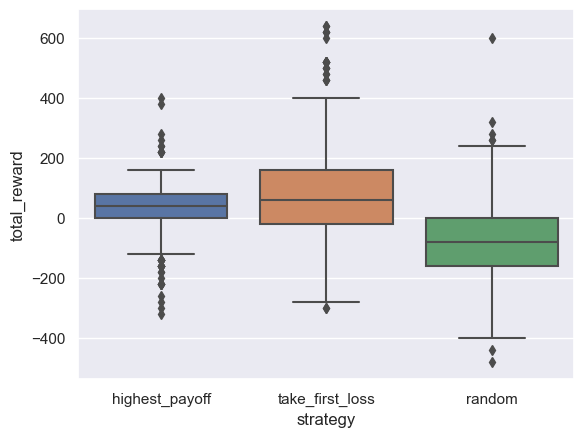

In [285]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=strategy_data_final['total_reward'],
                          groups=strategy_data_final['strategy'],
                          alpha=0.05)

#display results
print(tukey)

sns.boxplot(x="strategy", y="total_reward", data=strategy_data_final)
plt.show()

## Compare results

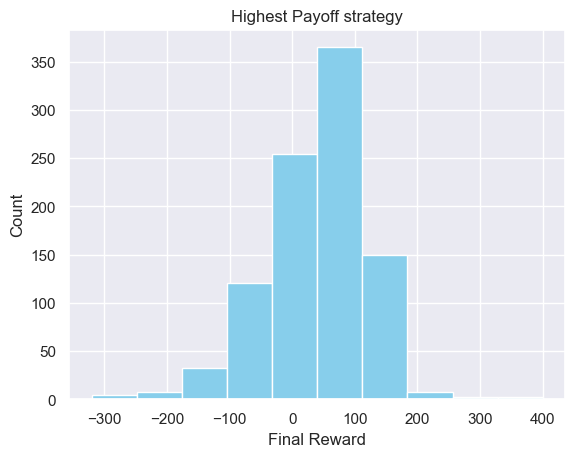

In [286]:
colors = {'highest_payoff':'skyblue','take_first_loss':'orangered','random':'springgreen'}

a = (torch.sum(resultsA,dim=1)).numpy()
plt.hist(a,color=colors['highest_payoff'])
plt.title('Highest Payoff strategy')
plt.xlabel('Final Reward')
plt.ylabel('Count')
plt.show()

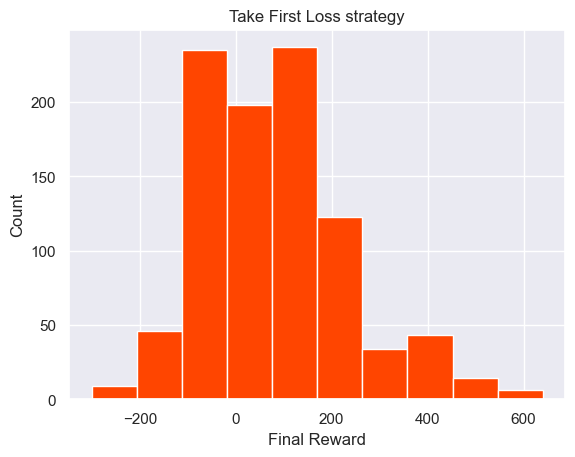

In [287]:
b = (torch.sum(resultsB,dim=1)).numpy()
plt.hist(b,color=colors['take_first_loss'])
plt.title('Take First Loss strategy')
plt.xlabel('Final Reward')
plt.ylabel('Count')
plt.show()

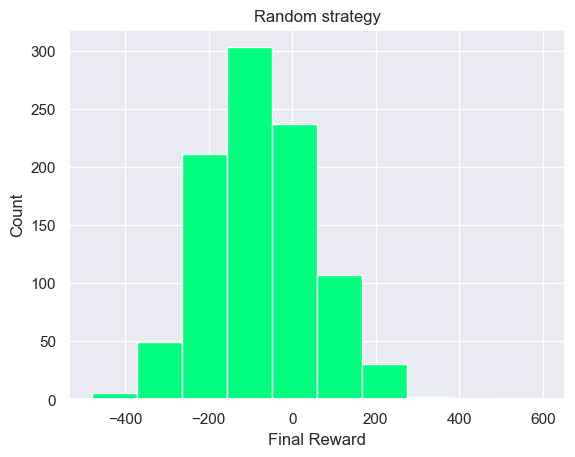

In [288]:
c = (torch.sum(resultsC,dim=1)).numpy()
plt.hist(c,color=colors['random'])
plt.title('Random strategy')
plt.xlabel('Final Reward')
plt.ylabel('Count')
plt.show()

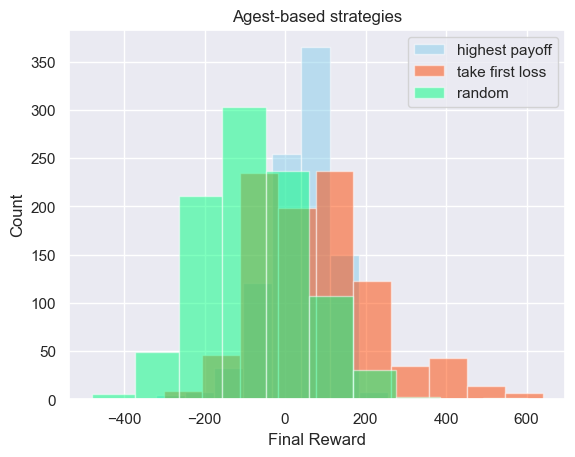

In [289]:
plt.hist(a,color=colors['highest_payoff'],alpha=0.5,label='highest payoff')
plt.hist(b,color=colors['take_first_loss'],alpha=0.5,label='take first loss')
plt.hist(c,color=colors['random'],alpha=0.5,label='random')
plt.legend(loc='upper right')
plt.title('Agest-based strategies')
plt.xlabel('Final Reward')
plt.ylabel('Count')
plt.show()

Avg reward at each step (highest payoff): tensor([3.3651, 1.8836, 4.3598, 3.6825, 7.9788, 4.0212, 6.5185, 6.0106])
Avg reward at each step (take first loss): tensor([-34.1164, -20.2963,  -2.8148,  22.6455,  31.5979,  28.9101,  28.2751,
         27.0053])
Avg reward at each step (random): tensor([-21.2910, -20.8889, -12.0847,  -9.7143,  -4.9947,  -3.9788,  -2.2011,
         -2.0952])


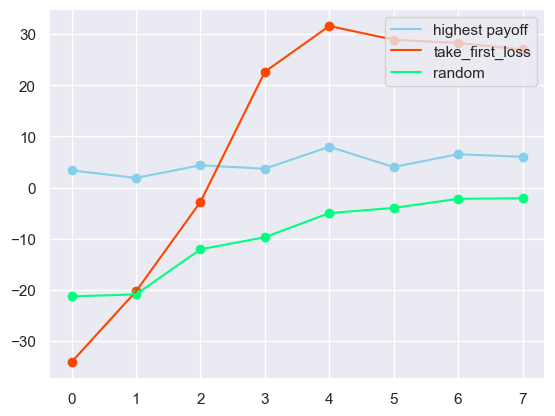

In [290]:
meanA = resultsA.mean(dim=0,dtype=torch.float)
print(f'Avg reward at each step (highest payoff): {meanA}')
meanB = resultsB.mean(dim=0,dtype=torch.float)
print(f'Avg reward at each step (take first loss): {meanB}')
meanC = resultsC.mean(dim=0,dtype=torch.float)
print(f'Avg reward at each step (random): {meanC}')

plt.scatter(np.arange(0,8),meanA,color=colors['highest_payoff'])
plt.plot(np.arange(0,8),meanA,color=colors['highest_payoff'],label='highest payoff')
plt.scatter(np.arange(0,8),meanB,color=colors['take_first_loss'])
plt.plot(np.arange(0,8),meanB,color=colors['take_first_loss'],label='take_first_loss')
plt.scatter(np.arange(0,8),meanC,color=colors['random'])
plt.plot(np.arange(0,8),meanC,color=colors['random'],label='random')
plt.legend(loc='upper right')
plt.show()

## Try Gym.Spaces to define observation space of the environment in order to use stable-baselines3?

https://stackoverflow.com/questions/56448260/how-could-i-define-the-observation-space-for-my-custom-openai-enviroment
https://github.com/openai/gym/blob/master/gym/spaces/graph.py
https://github.com/openai/gym/issues/2912

https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html (current version of env does not completely follow Gym API since we custom define the action and observation space without using the gym.spaces submodule)
https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html


The problem with the openai gym enviroments is that their space wrappers generate the action space and observation space but there doesn't seem to be much room for customization

A possibility could be to define `Tuple(Discrete(10),Discrete(10))` or `MultiDiscrete ([10,10])` for the action space, and a utility function to check if actions are valid in the current node you're at.

Observation space might be a bit trickier, should include at least current node, possible actions, step counter and done flag